# Laboratorio - Clasificación con Red convolucional
**José Barrios - 20007192**

## Descripción 
Para este laboratorio deberá utilizar Tensorflow/Keras para desarrollar un clasificador binario el cual permita realizar la clasificación de las observaciones proporcionadas (dataset de gatos y perros). Como métrica de referencia deberá generar un accuracy mínimo de 0.8, la idea del laboratorio es que usted entienda cómo funcionan las diferentes capas que forman una red neuronal convolucional y como esta puede ajustarse o modificar para mejorar los resultados de una predicción.


In [1]:
import keras as k
from keras.models import Sequential
from keras.layers import Dense #Creación de capas con neuronas
from keras.layers import Conv2D #Para trabajar la convolución 
from keras.layers import MaxPooling2D #Max pooling
from keras.layers import Flatten
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


### Uso de GPU
Determinar si el entrenamiento se puede procesar con la GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12511182593706870384
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5077532672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9833610652163723267
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# Ejecutar si en la intrucción de arriba se detectó una GPU
config = tf.compat.v1.ConfigProto( )#device_count = {'GPU': 1 , 'CPU': 2} ) 
#config.gpu_options.per_process_gpu_memory_fraction = 0.333
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

### Construcción de red
La red está dividida en dos partes. La primera es la red convolucional que realiza la extracción de features y detecta patrones en las imagenes. Se recomienda que las imagenes se cambien de tamaño a factores de 32 (32, 64, 138, etc.)

In [5]:
#Modelo de red convolucional - Feature extraction
cnn = Sequential() #Las capas se agregan secuencialmente

#Primera capa convolucional
cnn.add(Conv2D(filters=32, 
              kernel_size=(3, 3), 
              input_shape=(64, 64, 3), 
              activation='relu'))

#Capa de maxpooling
cnn.add(MaxPooling2D(pool_size=(4, 4)))

#Segunda capa convolucional
cnn.add(Conv2D(filters=24,  kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu'))

#Segunda Capa de maxpooling
cnn.add(MaxPooling2D(pool_size=(4, 4)))

#Capa de flattering
cnn.add(Flatten())

Construcción de red que realiza clasificación con base a los patrones detectados en la red convolucional.

In [6]:
#Red neuronal - Fully connected
#Primera capa de neuronas
# Usar input_size=X para otras capas ocultas
cnn.add(Dense(units=128, #Cantidad de neuronas. Se recomienda trabajar con potencias de 2
             activation='relu'))

#Capa de salida - Clasificación binaria
cnn.add(Dense(units=1, 
             activation='sigmoid'))

### Compilación de red

Definir los elementos que resolverán el problema.

In [7]:
cnn.compile(optimizer='adam', #Optimizador muy recomendado
           loss='binary_crossentropy', #Costo para problemas de clasificación binaria
           metrics=['accuracy'])

In [8]:
from keras.preprocessing.image import ImageDataGenerator

#Transformaciones de las imagenes de entrenamiento para enriquecer la entrada
train_datagen = ImageDataGenerator(
    rescale=1./255., 
    shear_range=0.2, #Giros aleatorios
    zoom_range=0.2, #Zooms aleatorios
    horizontal_flip=True 
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

strTrainDir = 'training_set/training_set'
strTestDir = 'test_set/test_set'

#Formaterar imagenes y estandarizar tamaños
train_set = train_datagen.flow_from_directory(
    strTrainDir, 
    target_size=(64, 64), 
    batch_size=32, 
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    strTestDir, 
    target_size=(64, 64), 
    batch_size=32, 
    class_mode='binary'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Configuración de entrenamiento

In [ ]:
#Usar si YA fue entrenado
#cnn.load_weights('model/pesos.h5')

In [9]:
#Usar si NO ha sido entrenado
cnn.fit(train_set, 
       steps_per_epoch=8000, 
       epochs=5, 
       validation_data=test_set, 
       validation_steps=2000, 
       verbose=1)

Epoch 1/5
8000/8000 [==============================] - 1046s 131ms/step - loss: 0.4256 - accuracy: 0.7971 - val_loss: 0.4269 - val_accuracy: 0.8129
Epoch 2/5
8000/8000 [==============================] - 1040s 130ms/step - loss: 0.2842 - accuracy: 0.8775 - val_loss: 0.8970 - val_accuracy: 0.8132
Epoch 3/5
8000/8000 [==============================] - 981s 123ms/step - loss: 0.2058 - accuracy: 0.9141 - val_loss: 0.4640 - val_accuracy: 0.8120
Epoch 4/5
8000/8000 [==============================] - 1038s 130ms/step - loss: 0.1571 - accuracy: 0.9360 - val_loss: 0.3487 - val_accuracy: 0.8225
Epoch 5/5
8000/8000 [==============================] - 1078s 135ms/step - loss: 0.1262 - accuracy: 0.9496 - val_loss: 0.1634 - val_accuracy: 0.8183


Se alcanzó un accuracy de 94.96%

Almacenamos los pesos de la red para poder utilizarla en otros ambientes si fuese necesario.

In [10]:
cnn.save_weights('model/pesos.h5')

In [ ]:
#from tensorflow.keras.models import load_model
#cnn = load_model(filepath, compile = True)

### Predicciones de prueba

In [30]:
import cv2
import matplotlib.pyplot  as plt
import numpy as np

In [32]:
def predict(img_dir, model):
    #Ajustar tamaño de imagen para entrada del modelo cnn
    img = cv2.imread(img_dir)
    img = cv2.resize(img, (64,64))
    
    #Obtener lista de posibles clases del modelo
    lista_clases = [*(train_set.class_indices).keys()]
    
    #Obtener clase a la que pertenece la imagen
    prediccion = model.predict_classes(np.array([img]))
    prediccion = lista_clases[prediccion[0][0]]
    
    #Mostrar resultado
    img = cv2.imread(img_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(prediccion)
    plt.imshow(img)

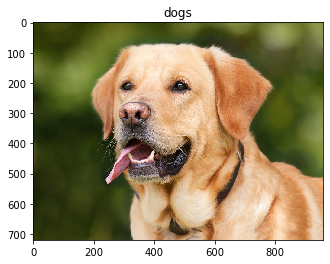

In [33]:
predict('single_prediction/cat_or_dog_1.jpg', cnn)

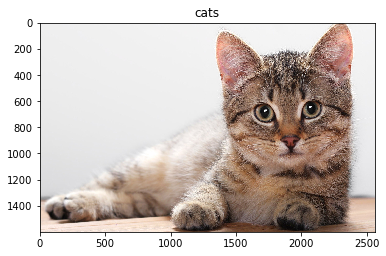

In [34]:
predict('single_prediction/cat_or_dog_2.jpg', cnn)

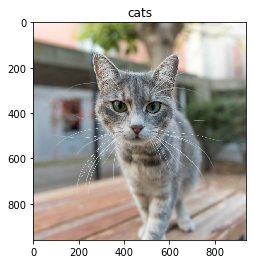

In [35]:
predict('single_prediction/cat_or_dog_3.jpg', cnn)

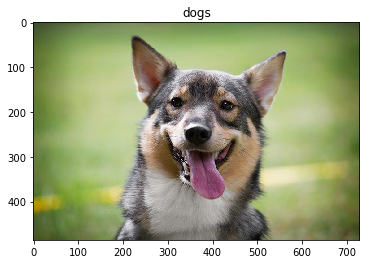

In [36]:
predict('single_prediction/cat_or_dog_4.jpg', cnn)